<a href="https://colab.research.google.com/github/thurarchive/Home-Credit-Scorecard-Model/blob/main/Home_Credit_Scorecard_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bayesian-optimization
!pip install seaborn --upgrade
!pip install matplotlib --upgrade

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
import gc
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import math
import pickle
import os

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from sklearn.model_selection import KFold, StratifiedKFold
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc, accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from datetime import datetime

In [ ]:
bureau_balance = pd.read_csv('/content/drive/My Drive/Rakamin/bureau_balance.csv')
bureau = pd.read_csv('/content/drive/My Drive/Rakamin/bureau.csv')
sample_submission = pd.read_csv('/content/drive/My Drive/Rakamin/sample_submission.csv')
credit_card_balance = pd.read_csv('/content/drive/My Drive/Rakamin/credit_card_balance.csv')
application_train = pd.read_csv('/content/drive/My Drive/Rakamin/application_train.csv')
homecredit_columns_description = pd.read_csv('/content/drive/My Drive/Rakamin/HomeCredit_columns_description.csv', encoding='latin1')
installments_payments = pd.read_csv('/content/drive/My Drive/Rakamin/installments_payments.csv')
POS_CASH_balance = pd.read_csv('/content/drive/My Drive/Rakamin/POS_CASH_balance.csv')
previous_application = pd.read_csv('/content/drive/My Drive/Rakamin/previous_application.csv')
application_test = pd.read_csv('/content/drive/My Drive/Rakamin/application_test.csv')

In [ ]:
# Data Cleaning

# List of all datasets and their names
datasets = [application_train, bureau, bureau_balance, POS_CASH_balance, credit_card_balance, previous_application, installments_payments]
dataset_names = ["application_train", "bureau", "bureau_balance", "POS_CASH_balance", "credit_card_balance", "previous_application", "installments_payments"]

for idx, dataset in enumerate(datasets):
    print(f"Handling missing values for {dataset_names[idx]}")

    # Impute numerical columns with median
    for col in dataset.select_dtypes(include=['float64', 'int64']).columns:
        dataset[col].fillna(dataset[col].median(), inplace=True)

    # Impute categorical columns with mode
    for col in dataset.select_dtypes(include=['object']).columns:
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)

# Sorting POS_CASH_balance
POS_CASH_balance = POS_CASH_balance.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])

# Sorting credit_card_balance
credit_card_balance = credit_card_balance.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])

# Sorting installments_payments
installments_payments = installments_payments.sort_values(by=['SK_ID_PREV', 'DAYS_INSTALMENT'])

# Printing confirmation
timeseries_names = ["POS_CASH_balance", "credit_card_balance", "installments_payments"]
for name in timeseries_names:
    print(f"Sorted data chronologically for {name}")

Handling missing values for application_train
Handling missing values for bureau
Handling missing values for bureau_balance
Handling missing values for POS_CASH_balance
Handling missing values for credit_card_balance
Handling missing values for previous_application
Handling missing values for installments_payments
Sorted data chronologically for POS_CASH_balance
Sorted data chronologically for credit_card_balance
Sorted data chronologically for installments_payments


In [ ]:
# Display the first few rows of the dataset
print(application_train.head())

# Display the shape and data types
print(application_train.shape)
print(application_train.dtypes)

# Display descriptive statistics
print(application_train.describe())



NameError: ignored

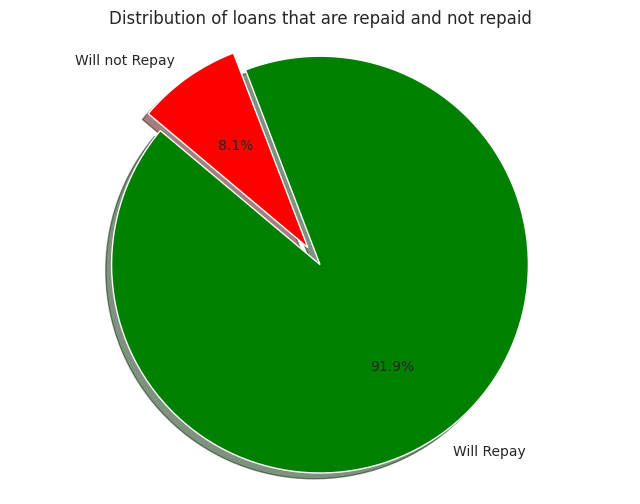

In [ ]:
# Refer :- https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

# Calculate value counts
y_value_counts = application_train['TARGET'].value_counts()

# Data to plot
labels = ['Will Repay', 'Will not Repay']
sizes = [y_value_counts[0], y_value_counts[1]]
colors = ['green', 'red']
explode = (0.1, 0)  # explode 1st slice for emphasis

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of loans that are repaid and not repaid')
plt.show()

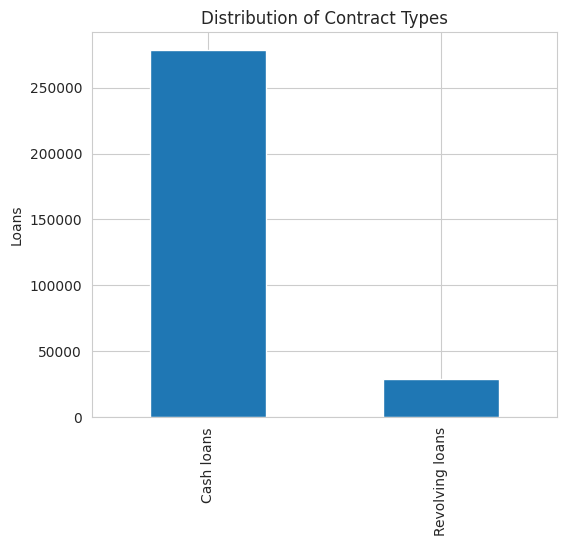

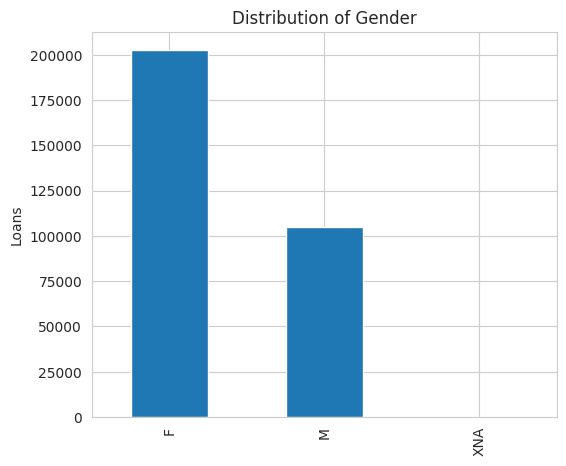

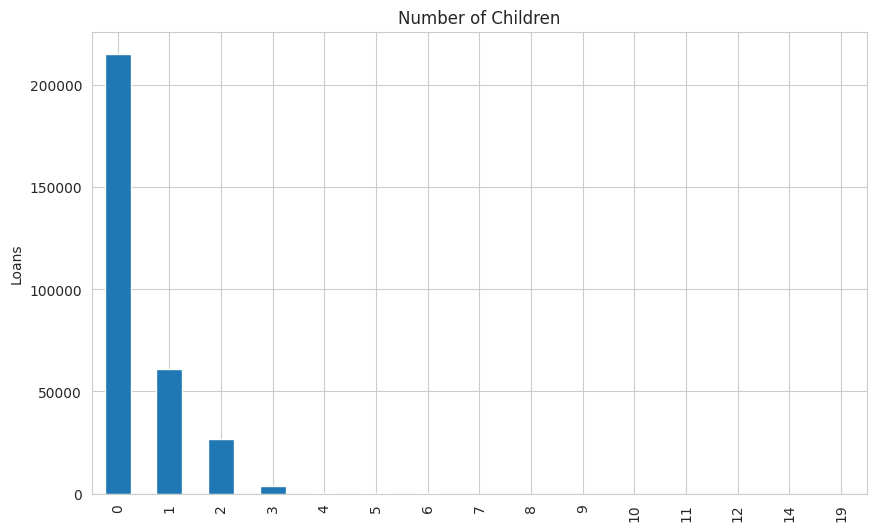

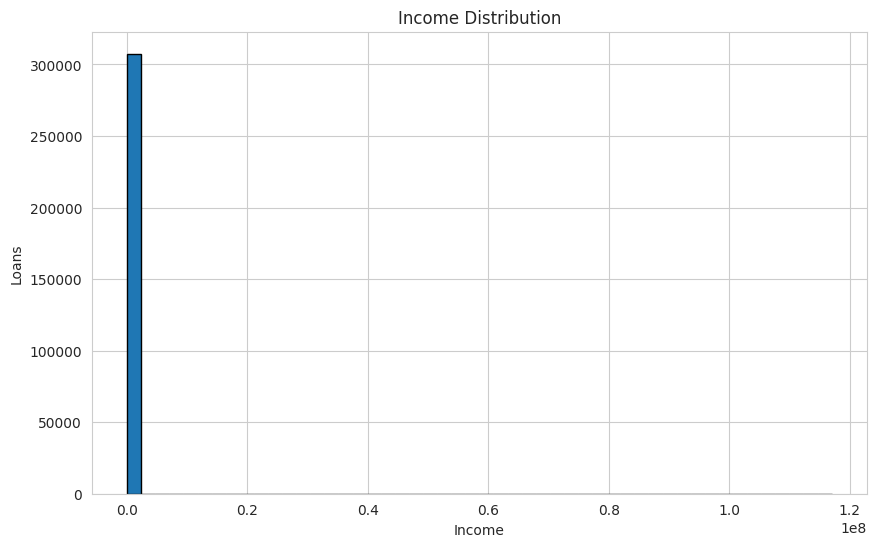

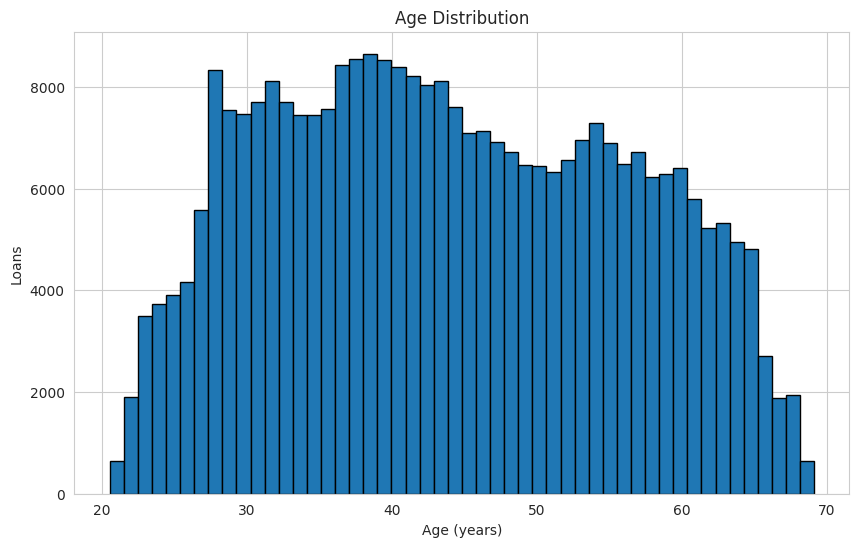

In [ ]:
import matplotlib.pyplot as plt

# 1. NAME_CONTRACT_TYPE
plt.figure(figsize=(6, 5))
application_train['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar')
plt.title('Distribution of Contract Types')
plt.ylabel('Loans')
plt.show()

# 2. CODE_GENDER
plt.figure(figsize=(6, 5))
application_train['CODE_GENDER'].value_counts().plot(kind='bar')
plt.title('Distribution of Gender')
plt.ylabel('Loans')
plt.show()

# 3. CNT_CHILDREN
plt.figure(figsize=(10, 6))
application_train['CNT_CHILDREN'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Children')
plt.ylabel('Loans')
plt.show()

# 4. AMT_INCOME_TOTAL
plt.figure(figsize=(10, 6))
plt.hist(application_train['AMT_INCOME_TOTAL'], bins=50, edgecolor='k')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Loans')
plt.show()

# 5. DAYS_BIRTH (converted to years for better understanding)
plt.figure(figsize=(10, 6))
plt.hist(application_train['DAYS_BIRTH']/-365, bins=50, edgecolor='k')  # Converting days to years
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Loans')
plt.show()

In [ ]:
# Calculate the values for annotations
grouped = application_train.groupby('NAME_CONTRACT_TYPE')['TARGET']
total = grouped.count()
avg = grouped.mean()

# Plotting
plt.figure(figsize=(6, 5))
application_train['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar')
plt.title('Distribution of Contract Types')
plt.ylabel('Loans')
plt.show()

# Printing the annotations
print("NAME_CONTRACT_TYPE  TARGET  total      AVG")
print("------------------------------------------------")
for type in total.index:
    print(f"{type: <18} {total[type]: <7} {avg[type]:.6f}")

NameError: ignored